In [1]:
# Receiver Operator Charateristic (ROC) Analysis
# Create the final patient survival dataset WITH APACHE II, III and IV scores included
# 1. Dropping the following fields:
    # - height and weight (because they are respresented in the bmi calculation)
    # - ***unique ids (encounter and patient) will be removed from the final ML dataset
# 2. Dropping columns with more than 5000 missing values
# 3. Encoding 'object' values
# 4. Dropping patients with missing values

# ROC...

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from imblearn.metrics import classification_report_imbalanced
from scipy import stats
import seaborn as sns

In [30]:
# Bringing the patient survival datset into notebook
database_a_2 = pd.read_csv("Dataset.csv")

In [31]:
# Plotting columns by percentage of values that are null
missing_data = pd.DataFrame([database_a_2.isna().mean()]).T
missing_data = missing_data.rename(columns={0: "apache_2_missing"})

In [32]:
# Dropping height and weight 
database_apache_2 = database_a_2.drop(['height', 'weight'], axis=1)

In [33]:
# Counting columns with more than 5000 missing values
missing_value_fields = database_apache_2.isnull().sum(axis=0).sort_values(ascending=False)[database_apache_2.isnull().sum(axis=0).sort_values(ascending=False) > 25000]

print("\nTotal features with more than", 25000, "missing values:", len(missing_value_fields))


Total features with more than 25000 missing values: 74


In [34]:
# Dropping columns with more than 5000 missing values
database_apache_2.drop(missing_value_fields.index.tolist(), axis=1, inplace = True)

In [35]:
# Identifying columns with 'object' data type
object_list = database_apache_2.select_dtypes(include = "object").columns
print (object_list)

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')


In [36]:
# Encoding columns with 'object' data type
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in object_list:
    database_apache_2[feat] = le.fit_transform(database_apache_2[feat].astype(str))

In [37]:
# Dropping rows(patients) with missing values in any column
database_roc = database_apache_2.dropna()

In [38]:
database_roc

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,hospital_admit_source,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,2,1,4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9,0
1,114252,59342,81,0,77.0,27.420000,0,2,0,4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8,6
5,33181,74489,83,0,67.0,27.560000,0,2,1,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7,4
9,42871,90749,118,0,50.0,25.710000,0,6,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
17,22471,112115,118,0,46.0,25.845717,0,3,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91692,125145,56872,30,0,36.0,20.575852,0,2,0,15,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,3
91698,83806,68549,195,0,47.0,51.439842,1,2,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
91706,127138,59223,121,0,54.0,19.770448,0,4,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
91709,66119,13486,121,0,56.0,47.179671,0,2,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0


In [39]:
# Converting df to csv
database_roc.to_csv('database_roc.csv')

In [40]:
# ROC...

#define the predictor variables and the response variable
X = database_roc[['temp_apache', 'map_apache', 'heart_rate_apache', 'resprate_apache', 
                  'sodium_apache', 'd1_potassium_max', 'd1_potassium_min', 'creatinine_apache', 
                  'hematocrit_apache', 'wbc_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 
                  'age', 'elective_surgery', 'apache_post_operative']]
y = database_roc['hospital_death']

#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=0) 

#instantiate the model
log_regression_apache_2 = LogisticRegression()

#fit the model using the training data
log_regression_apache_2.fit(X_train,y_train)

#classifier = LogisticRegression(solver='lbfgs',
   #max_iter=200,
   #random_state=1)

#'fio2_apache', 'pao2_apache', 'ph_apache',

/Users/brianbutler/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

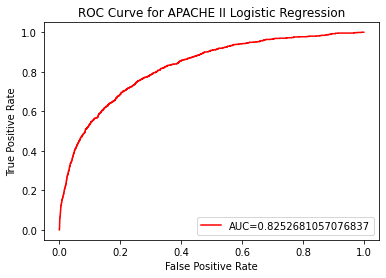

In [46]:
#define metrics
y_pred_proba = log_regression_apache_2.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,color='red',label="AUC="+str(auc))
plt.title('ROC Curve for APACHE II Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [15]:
# Bringing in our model(s) to compare to the APACHE II results

In [16]:
#file_path = Path("C:/Users/emili/Class/Patient_Survival_Prediction/Database/database_patient.csv")

df_patient = pd.read_csv("database_patient.csv")
#df_psp = pd.read_csv(file_path)
df_patient.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,icu_admit_source,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68,22.73,0,2,1,1,...,0,0,1,0,0,0,0,0,9,0
1,114252,59342,81,0,77,27.42,0,2,0,1,...,0,0,1,0,0,0,0,0,8,6
2,119783,50777,118,0,25,31.95,0,2,0,0,...,0,0,0,0,0,0,0,0,5,3
3,79267,46918,118,0,81,22.64,1,2,0,2,...,0,0,0,0,0,0,0,0,0,0
4,33181,74489,83,0,67,27.56,0,2,1,0,...,0,0,1,0,0,0,0,0,7,4


In [17]:
# Create our features

X = df_patient.drop('hospital_death', axis=1)


X.head()


,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_id,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,68,22.73,0,2,1,1,92,...,0,0,1,0,0,0,0,0,9,0
1,114252,59342,81,77,27.42,0,2,0,1,90,...,0,0,1,0,0,0,0,0,8,6
2,119783,50777,118,25,31.95,0,2,0,0,93,...,0,0,0,0,0,0,0,0,5,3
3,79267,46918,118,81,22.64,1,2,0,2,92,...,0,0,0,0,0,0,0,0,0,0
4,33181,74489,83,67,27.56,0,2,1,0,95,...,0,0,1,0,0,0,0,0,7,4


In [18]:
X.describe()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_id,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
count,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,...,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000
mean,65654.462341,65551.914512,106.463992,62.371038,29.317898,0.184134,2.035080,0.543706,0.689157,516.566078,...,0.000942,0.016543,0.229068,0.013827,0.027722,0.007480,0.004081,0.021662,4.378600,2.592640
std,37769.374703,37792.056466,63.245110,16.764922,8.292887,0.387596,1.067173,0.498227,0.939700,223.889032,...,0.030675,0.127554,0.420236,0.116774,0.164178,0.086164,0.063755,0.145578,3.827921,2.839358
min,1.000000,1.000000,2.000000,16.000000,14.844926,0.000000,0.000000,0.000000,0.000000,82.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32879.250000,32841.500000,49.000000,52.000000,23.739453,0.000000,2.000000,0.000000,0.000000,376.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65844.500000,65466.000000,112.000000,65.000000,27.812500,0.000000,2.000000,1.000000,0.000000,504.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000
75%,98326.750000,98282.750000,166.000000,75.000000,33.091592,0.000000,2.000000,1.000000,1.000000,684.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000
max,131051.000000,131051.000000,204.000000,89.000000,67.814990,1.000000,6.000000,2.000000,5.000000,927.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,10.000000


In [19]:
# Create our target

y = df_patient['hospital_death']
y.value_counts()

0    67400
1     5862
Name: hospital_death, dtype: int64

In [20]:
# Split data into training and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [21]:
# Check balances
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 50550, 1: 4396})
Counter({0: 16850, 1: 1466})


In [22]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Instantiate
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# Fit
brfc.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

In [23]:
# Calculated the balanced accuracy score
#y_pred = brfc.predict(X_test)
#RandomForest_accuracy = balanced_accuracy_score(y_test, y_pred)

#RandomForest_accuracy

In [42]:
#define metrics
y_pred_proba = brfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

/Users/brianbutler/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- creatinine_apache
- d1_potassium_max
- d1_potassium_min
- hematocrit_apache
- sodium_apache
- ...
Feature names seen at fit time, yet now missing:
- aids
- apache_2_bodysystem
- apache_3j_bodysystem
- arf_apache
- bmi
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 16 features, but BalancedRandomForestClassifier is expecting 68 features as input.

In [24]:
# Display the confusion matrix
# Calculating the confusion matrix
#cm = confusion_matrix(y_test, y_pred)


# Create a DataFrame from the confusion matrix.
#cm_df = pd.DataFrame(
    #cm, index=["Actual Survival", "Actual Death"], columns=["Predicted Survival", "Predicted Death"])

#cm_df

In [25]:
# Print the imbalanced classification report
#print(classification_report_imbalanced(y_test, y_pred))

In [26]:
# List the features sorted in descending order by feature importance
#features_rank = sorted(zip(brfc.feature_importances_, X.columns), reverse=True)
#for feature in features_rank:
    #print(f"{feature[1]}: ({feature[0]})")

In [28]:
disp = plot_roc_curve(log_regression_apache_2, X_test, y_test)
plot_roc_curve(brfc, X_test, y_test);

/Users/brianbutler/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/brianbutler/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- aids
- apache_2_bodysystem
- apache_3j_bodysystem
- arf_apache
- bmi
- ...
Feature names seen at fit time, yet now missing:
- creatinine_apache
- d1_potassium_max
- d1_potassium_min
- hematocrit_apache
- sodium_apache
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 68 features, but LogisticRegression is expecting 16 features as input.

In [ ]:
#Show the importance of each feature in a graph

Features = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["Importance"], index=X_train.columns)



Features = Features.sort_values(by="Importance", ascending=False)[:40]

plt.figure(figsize=(15, 10))
sns.barplot(x="Importance", y=Importance.index, data=Importance)
plt.title("Features by Importance")
plt.show()

Importance.head()

In [ ]:
# Easy Ensemble Classifer
# Train the EasyEnsembleClassifier

from imblearn.ensemble import EasyEnsembleClassifier

# Instantiate

eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)

# Fit
eec.fit(X_train, y_train)

In [ ]:
# Calculated the balanced accuracy score

y_pred = eec.predict(X_test)
EasyEnsemble_accuracy = balanced_accuracy_score(y_test, y_pred)

EasyEnsemble_accuracy

In [ ]:
# Display the confusion matrix
# Calculating the confusion matrix

cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual Survival", "Actual Death"], columns=["Predicted Survival", "Predicted Death"])
cm_df

In [ ]:
# Print the imbalanced classification report

print(classification_report_imbalanced(y_test, y_pred))

In [ ]:
# Report the accuracy scores of both models


Accuracy=[(RandomForest_accuracy*100),(EasyEnsemble_accuracy*100)]

  
df = {'Algorithm': ['Random Forest Classifier','Easy Ensemble Classifier'], \
      'Acuuracy_Score':Accuracy}


Accuracy_Scores = pd.DataFrame(data=df, columns=['Algorithm','Acuuracy_Score'], index=None)

Accuracy_Scores